# 1. Importing Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
import random
import torchvision

from typing import List, Dict, Tuple
from torch import nn
from torchvision.transforms import transforms
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from datetime import datetime

from helper_functions import create_dataloaders, set_seeds, display_random_images, plot_loss_curves, save_model, load_model
from engine import train, create_writer, pred_and_store

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
AMOUNT_TO_GET = 1.0
SEED = 42
ENABLE = {
    'train_model': True,
    'save_model':  True,    
}

# Define target data directory
#target_dir_name = f"../data/pizza_steak_sushi_applepie_hamburger_{str(int(AMOUNT_TO_GET*100))}_percent"
target_dir_name = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Create image size
IMG_SIZE = 288

manual_transforms = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm_test = v2.Compose([        
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

pretrained_resnetb2_transforms = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

In [4]:
print(f"Default EfficientNetB2 transforms: {pretrained_resnetb2_transforms}")

Default EfficientNetB2 transforms: ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [5]:
# Setup the directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

# Create data loaders
train_dataloader_b2, test_dataloader_b2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

#train_dataloader_b2, test_dataloader_b2, class_names

# 3. Image Visualization

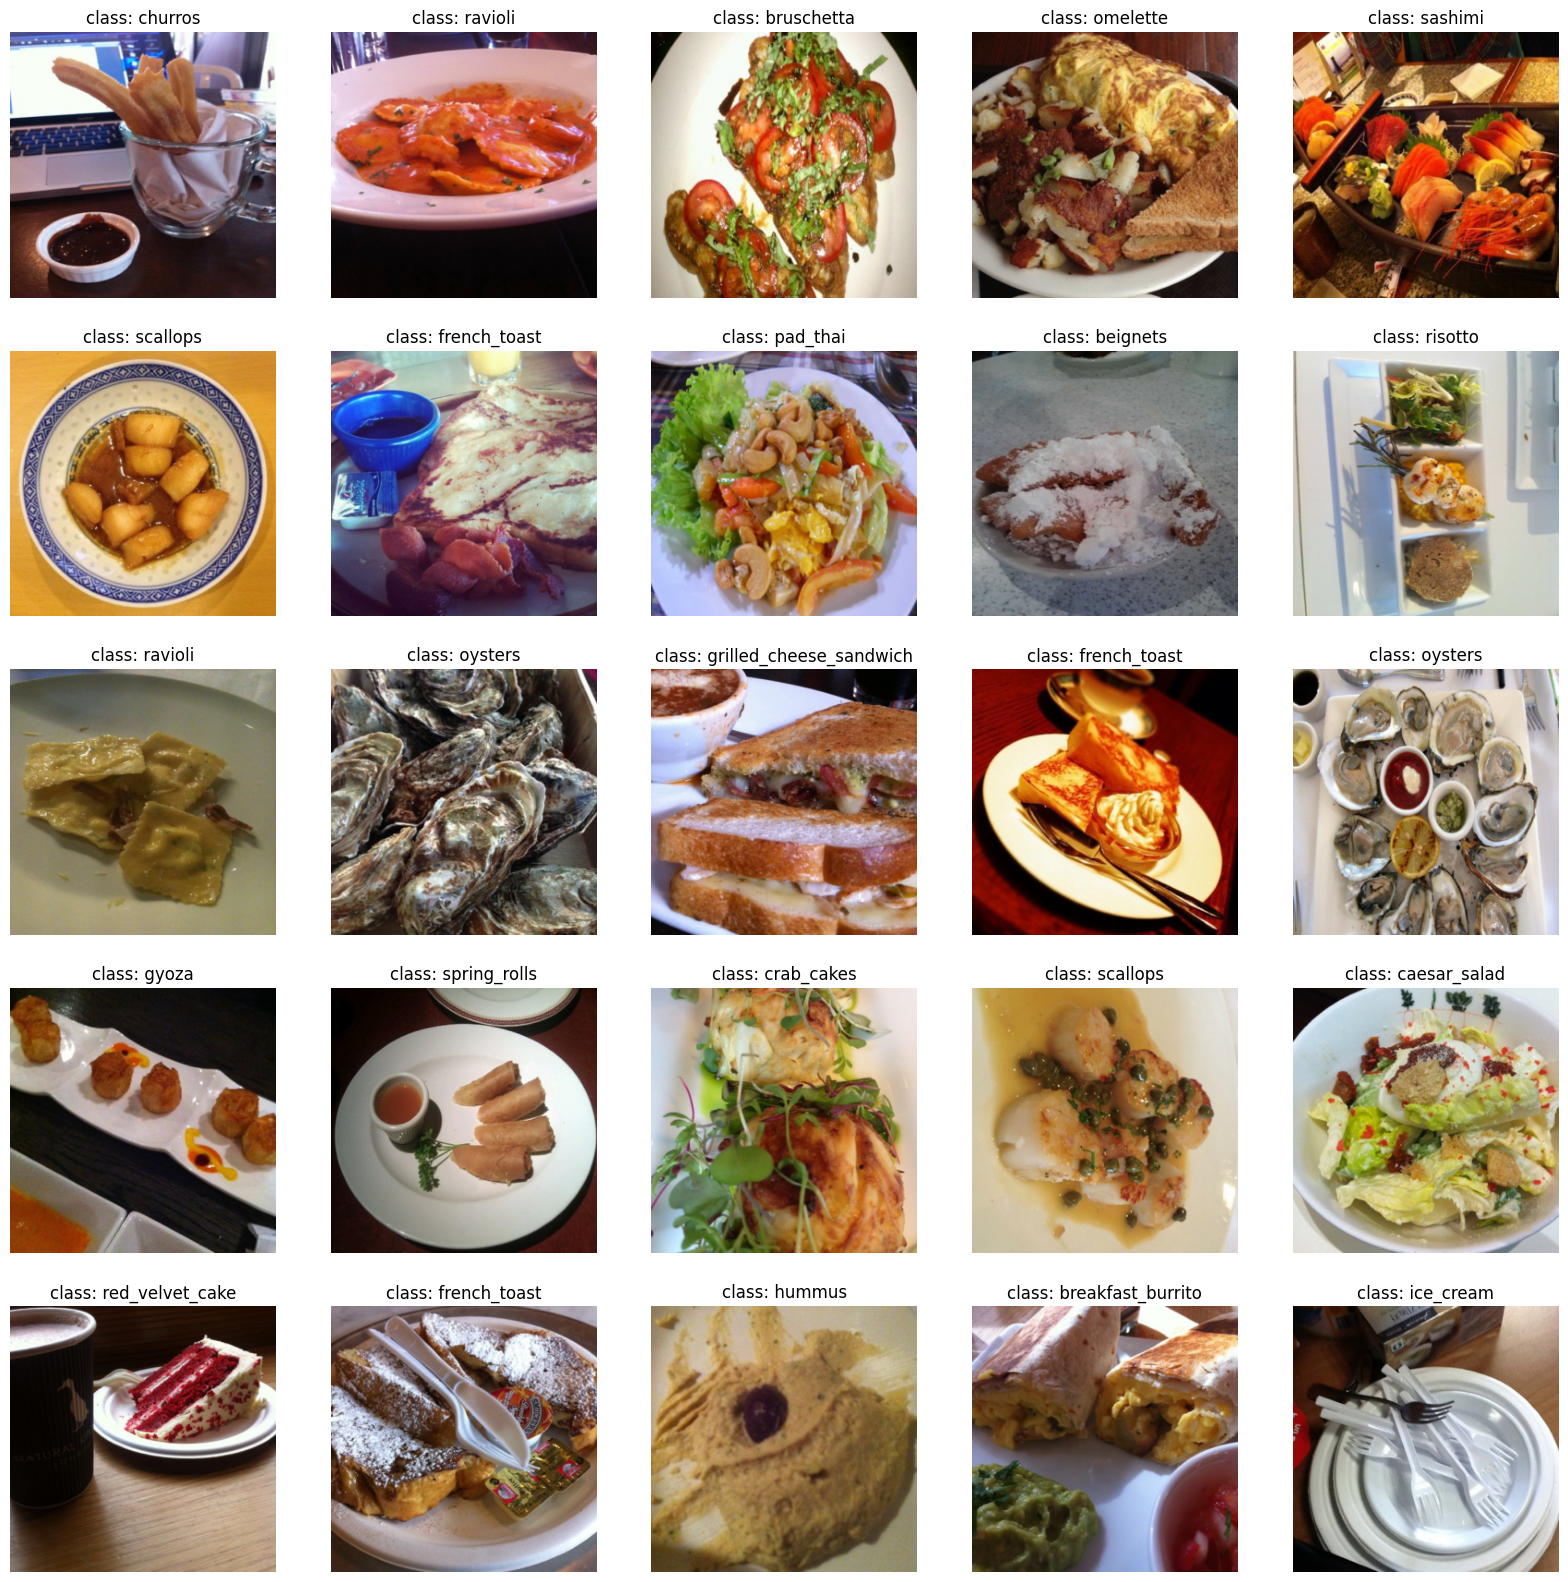

In [6]:
with torch.device("cpu"):
    train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
    display_random_images(train_data,
                          n=25,
                          classes=class_names,
                          rows=5,
                          cols=5,
                          display_shape=False,
                          seed=None)

# 4. Baseline Model: EfficientNet B2

## 4.1 Version 1

In [7]:
# Create an EfficientNet-B0 Model
def create_effnetb2(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    if transfer_learning:
        weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout, inplace=True), 
        torch.nn.Linear(in_features=1408, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True))
        
    return model, weights

# Instantiate the model
effnetb2_model, effnetb2_weights = create_effnetb2(transfer_learning=True,
                                                   class_names=class_names)

# Compile model
torch.compile(effnetb2_model)

# Move the model to device
#effnetb2_model.to(device)

# Print its architecture
print(effnetb2_model)

# And a summary
summary(effnetb2_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 101]            --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

Epoch: 30 | train_loss: 2.4036 | train_acc: 0.5489 | test_loss: 2.0311 | test_acc: 0.6555 | lr: 0.0001000000 


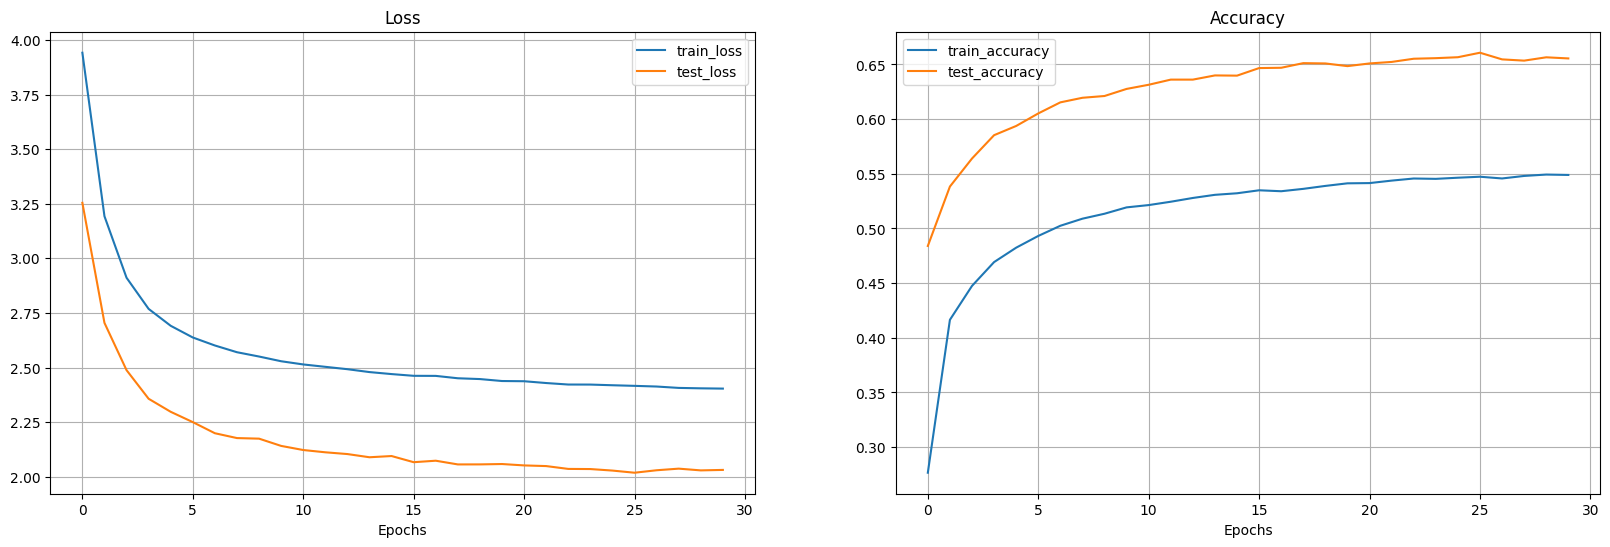

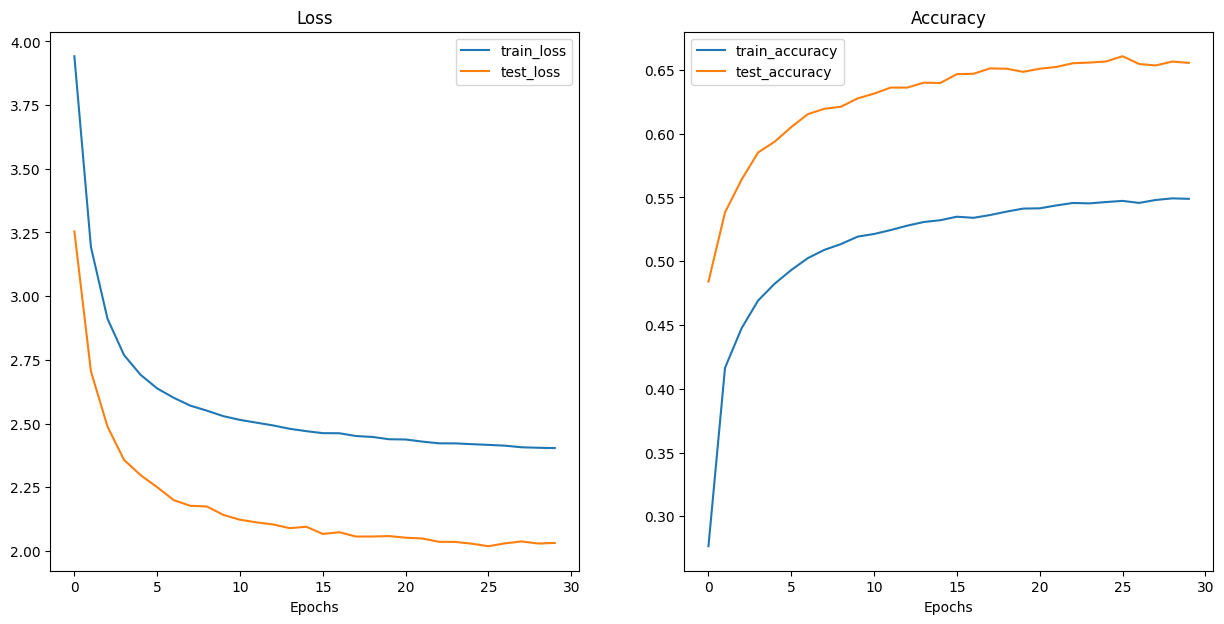

In [ ]:
model_type="effnetb2"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
effnetb2_model_name = model_name + ".pth"
effnetb2_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb2_model_name}")
print(f"Results path: {effnetb2_results_df}")

# Train the model
if ENABLE['train_model']:
    # Create an example writer
    #vitbase_writer = create_writer(experiment_name="data_100_percent",
    #                               model_name=model_name,
    #                               extra=f"{EPOCHS}_epochs")
    
    # Create optimizer
    optimizer = torch.optim.AdamW(params=effnetb2_model.parameters(),
                                lr=LR,
                                betas=(0.9, 0.999),
                                weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)


    # Train the classifier
    set_seeds(SEED)
    # Train the classifier
    effnetb2_results = train(model=effnetb2_model, 
                             train_dataloader=train_dataloader_b2,
                             test_dataloader=test_dataloader_b2,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             scheduler=None,
                             epochs=EPOCHS,
                             device=device,
                             plot_curves=True,
                             writer=None)

In [ ]:
# Save the EfficientNet B2 model
if ENABLE['save_model']:
   save_model(model=effnetb2_model,
              target_dir=model_dir,
              model_name=effnetb2_model_name)
   df_results = pd.DataFrame(effnetb2_results)
   df_results.to_csv(os.path.join(model_dir, effnetb2_results_df), index=False)  

[INFO] Saving model to: ..\models\effnetb2_lr0001_30epochs.pth


## 4.2 Version 2

In [ ]:
# Instantiate the model
effnetb2_2_model, effnetb2_2_weights = create_effnetb2(transfer_learning=True,
                                                       class_names=class_names)

# Compile model
torch.compile(effnetb2_2_model)

# Move the model to device
#effnetb2_model.to(device)

# Print its architecture
print(effnetb2_2_model)

In [ ]:
model_type="effnetb2_v2"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
effnetb2_2_model_name = model_name + ".pth"
effnetb2_2_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb2_2_model_name}")
print(f"Results path: {effnetb2_2_results_df}")

Model name: effnetb2_v2_lr000001_30epochs
Model path: effnetb2_v2_lr000001_30epochs.pth
Results path: effnetb2_v2_lr000001_30epochs.csv


Epoch: 30 | train_loss: 2.4678 | train_acc: 0.5329 | test_loss: 2.0873 | test_acc: 0.6402 | lr: 0.0000905463 


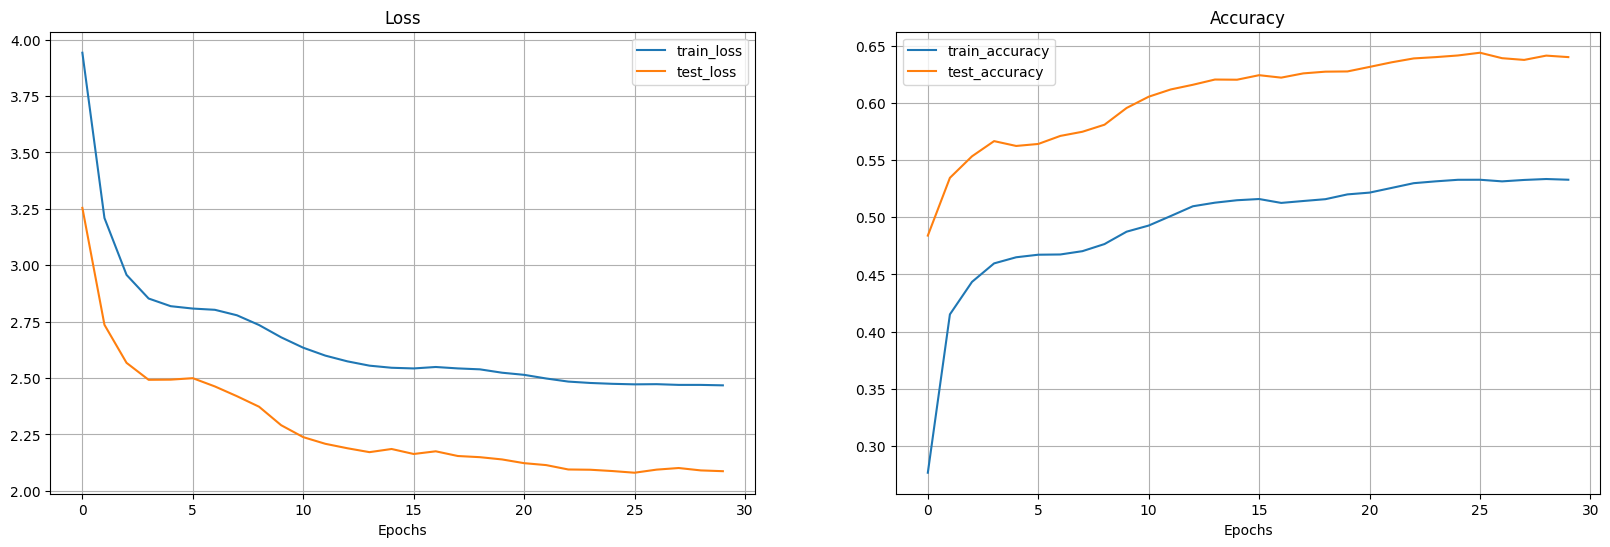

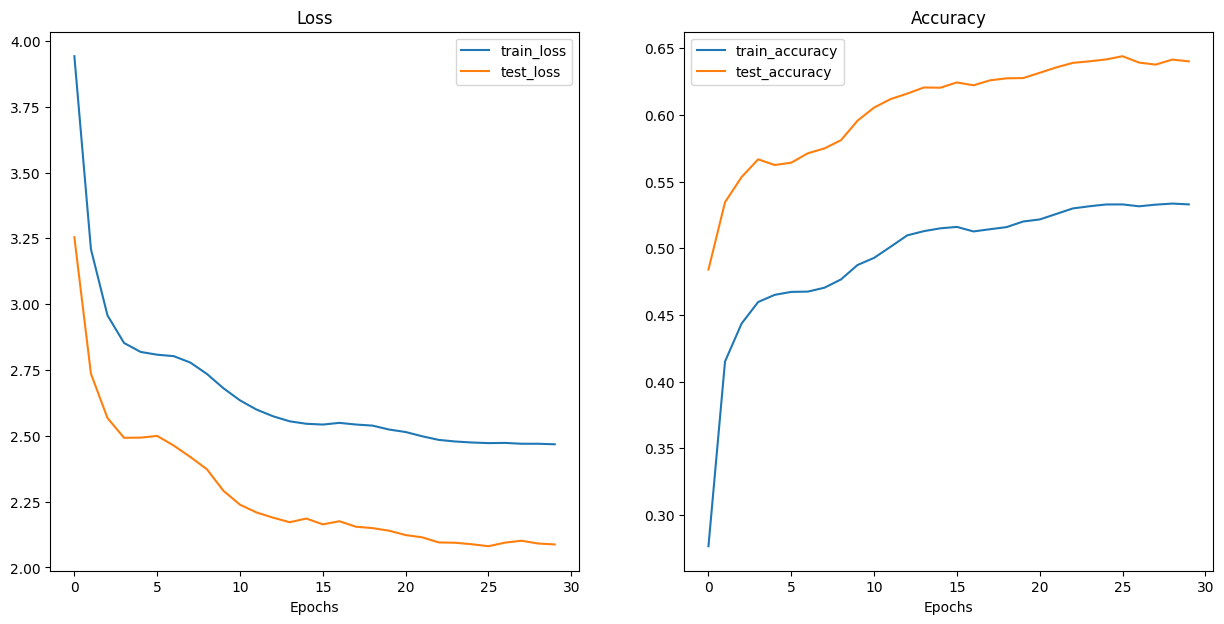

In [ ]:
# Train the model
if ENABLE['train_model']:
    # Create an example writer
    #vitbase_writer = create_writer(experiment_name="data_100_percent",
    #                               model_name=model_name,
    #                               extra=f"{EPOCHS}_epochs")
    
    # Create optimizer
    optimizer = torch.optim.AdamW(params=effnetb2_model.parameters(),
                                lr=LR,
                                betas=(0.9, 0.999),
                                weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)


    # Train the classifier
    set_seeds(SEED)
    # Train the classifier
    effnetb2_2_results = train(model=effnetb2_2_model, 
                               train_dataloader=train_dataloader_b2,
                               test_dataloader=test_dataloader_b2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               scheduler=scheduler,
                               epochs=EPOCHS,
                               device=device,
                               plot_curves=True,
                               writer=None)

In [ ]:
# Save the EfficientNet B2 model
if ENABLE['save_model']:
   save_model(model=effnetb2_2_model,
              target_dir=model_dir,
              model_name=effnetb2_2_model_name)
   df_results = pd.DataFrame(effnetb2_2_results)
   df_results.to_csv(os.path.join(model_dir, effnetb2_2_results_df), index=False)

[INFO] Saving model to: ..\models\effnetb2_v2_lr000001_30epochs.pth


## 4.3 Version 3

In [ ]:
# Create data loaders
BATCH_SIZE = 64
train_dataloader_b2, test_dataloader_b2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# Instantiate the model
effnetb2_3_model, effnetb2_3_weights = create_effnetb2(transfer_learning=True,
                                                       class_names=class_names)

# Compile model
torch.compile(effnetb2_3_model)

Model name: effnetb2_v3_lr000001_30epochs
Model path: effnetb2_v3_lr000001_30epochs.pth
Results path: effnetb2_v3_lr000001_30epochs.csv


Epoch: 30 | train_loss: 2.3907 | train_acc: 0.5547 | test_loss: 2.0287 | test_acc: 0.6547 | lr: 0.0001000000 


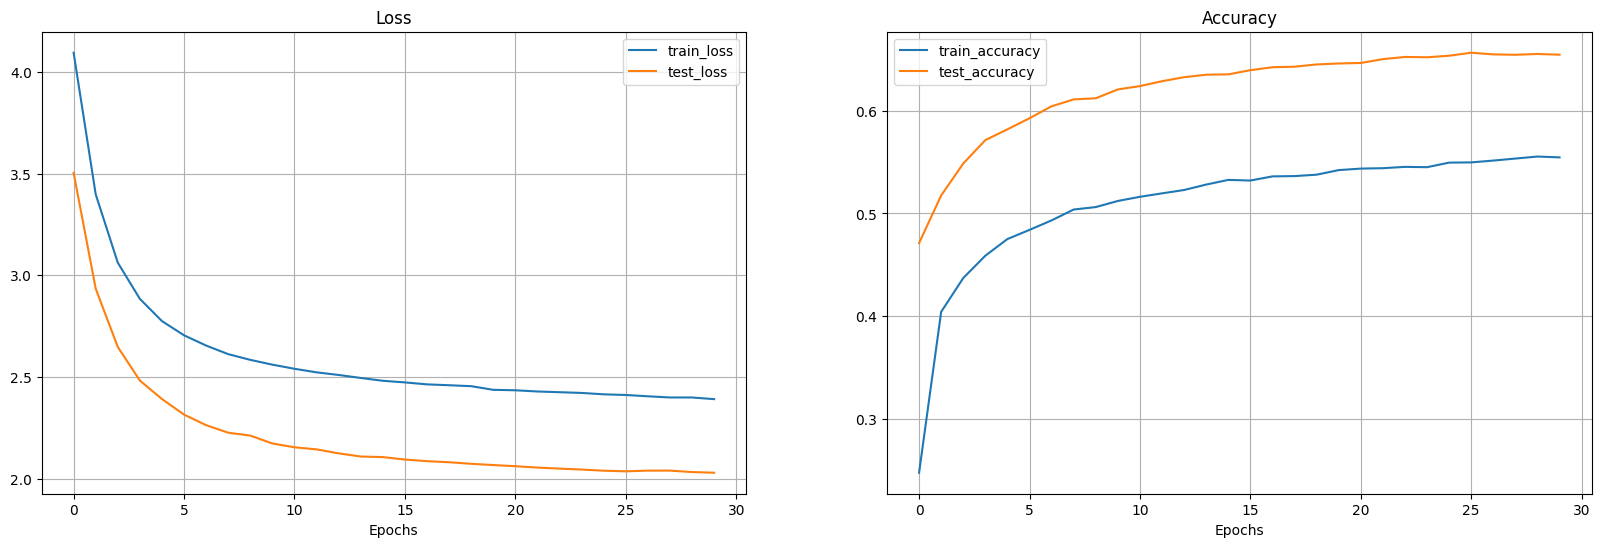

In [ ]:
# Configure the model
model_type="effnetb2_v3"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
effnetb2_3_model_name = model_name + ".pth"
effnetb2_3_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb2_3_model_name}")
print(f"Results path: {effnetb2_3_results_df}")

# Train the model
if ENABLE['train_model']:
    # Create an example writer
    #vitbase_writer = create_writer(experiment_name="data_100_percent",
    #                               model_name=model_name,
    #                               extra=f"{EPOCHS}_epochs")
    
    # Create optimizer
    optimizer = torch.optim.AdamW(params=effnetb2_3_model.parameters(),
                                lr=LR,
                                betas=(0.9, 0.999),
                                weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)


    # Train the classifier
    set_seeds(SEED)
    # Train the classifier
    effnetb2_3_results = train(model=effnetb2_3_model, 
                               train_dataloader=train_dataloader_b2,
                               test_dataloader=test_dataloader_b2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               scheduler=None,
                               epochs=EPOCHS,
                               device=device,
                               plot_curves=True,
                               writer=None)

In [ ]:
# Save the EfficientNet B2 model
if ENABLE['save_model']:
   save_model(model=effnetb2_3_model,
              target_dir=model_dir,
              model_name=effnetb2_3_model_name)
   df_results = pd.DataFrame(effnetb2_3_results)
   df_results.to_csv(os.path.join(model_dir, effnetb2_3_results_df), index=False)

[INFO] Saving model to: ..\models\effnetb2_v3_lr000001_30epochs.pth


## 4.4. Version 4

In [7]:
def create_effnetb2_v2(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        hidden_units: int=1024,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    if transfer_learning:
        weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout), 
        torch.nn.Linear(in_features=1408, 
                        out_features=hidden_units, # same number of output units as our number of classes
                        bias=True),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=dropout), 
        torch.nn.Linear(in_features=hidden_units, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)
    )

    return model, weights

In [8]:
# Create data loaders
BATCH_SIZE = 64
HIDDEN_UNITS = 1024
train_dataloader_b2, test_dataloader_b2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# Instantiate the model
effnetb2_4_model, _ = create_effnetb2_v2(transfer_learning=True,
                                         hidden_units=1024,
                                         class_names=class_names)

# Compile model
torch.compile(effnetb2_4_model)

# And a summary
summary(effnetb2_4_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 288, 288]    [64, 101]            --                   Partial
├─Sequential (features)                                      [64, 3, 288, 288]    [64, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 288, 288]    [64, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 288, 288]    [64, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 144, 144]   [64, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 144, 144]   [64, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [64, 32, 144, 144]   [64, 

In [9]:
# Configure the model
model_type="effnetb2_v4"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
effnetb2_4_model_name = model_name + ".pth"
effnetb2_4_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb2_4_model_name}")
print(f"Results path: {effnetb2_4_results_df}")

Model name: effnetb2_v4_lr000100_30epochs
Model path: effnetb2_v4_lr000100_30epochs.pth
Results path: effnetb2_v4_lr000100_30epochs.csv


Epoch: 30 | train_loss: 2.2543 | train_acc: 0.5845 | test_loss: 1.9238 | test_acc: 0.6790 | lr: 0.0001000000 


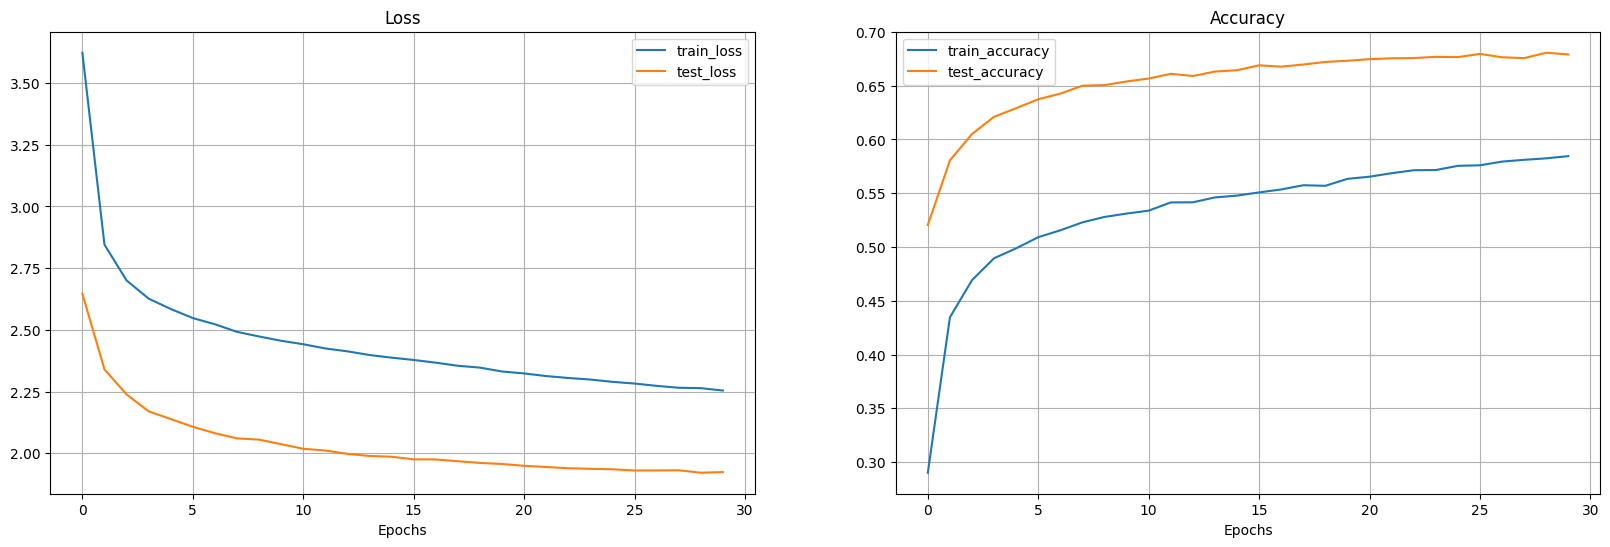

In [ ]:
# Train the model
if ENABLE['train_model']:
   
    # Create optimizer
    optimizer = torch.optim.AdamW(params=effnetb2_4_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)


    # Train the classifier
    set_seeds(SEED)
    
    # Train the classifier
    effnetb2_4_results = train(model=effnetb2_4_model, 
                               train_dataloader=train_dataloader_b2,
                               test_dataloader=test_dataloader_b2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               scheduler=None,
                               epochs=EPOCHS,
                               device=device,
                               plot_curves=True,
                               writer=None)

In [ ]:
# Save the EfficientNet B2 model
if ENABLE['save_model']:
   save_model(model=effnetb2_4_model,
              target_dir=model_dir,
              model_name=effnetb2_4_model_name)
   df_results = pd.DataFrame(effnetb2_4_results)
   df_results.to_csv(os.path.join(model_dir, effnetb2_4_results_df), index=False)

[INFO] Saving model to: ..\models\effnetb2_v4_lr000100_30epochs.pth


## 4.5 Version 5

Trainning with more epochs.

In [8]:
# Create data loaders
BATCH_SIZE = 64
HIDDEN_UNITS = 1024
train_dataloader_b2, test_dataloader_b2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# Instantiate the model
effnetb2_5_model, _ = create_effnetb2_v2(transfer_learning=True,
                                         hidden_units=1024,
                                         class_names=class_names)

# Compile model
torch.compile(effnetb2_5_model)

# And a summary
summary(effnetb2_5_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 288, 288]    [64, 101]            --                   Partial
├─Sequential (features)                                      [64, 3, 288, 288]    [64, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 288, 288]    [64, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 288, 288]    [64, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 144, 144]   [64, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 144, 144]   [64, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [64, 32, 144, 144]   [64, 

In [9]:
# Configure the model
model_type="effnetb2_v5"
EPOCHS = 50
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
effnetb2_5_model_name = model_name + ".pth"
effnetb2_5_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb2_5_model_name}")
print(f"Results path: {effnetb2_5_results_df}")

Model name: effnetb2_v5_lr000100_50epochs
Model path: effnetb2_v5_lr000100_50epochs.pth
Results path: effnetb2_v5_lr000100_50epochs.csv


Epoch: 50 | train_loss: 2.1384 | train_acc: 0.6171 | train_time: 3m15s | test_loss: 1.8942 | test_acc: 0.6870 | test_time: 1m38s | lr: 0.0001000000


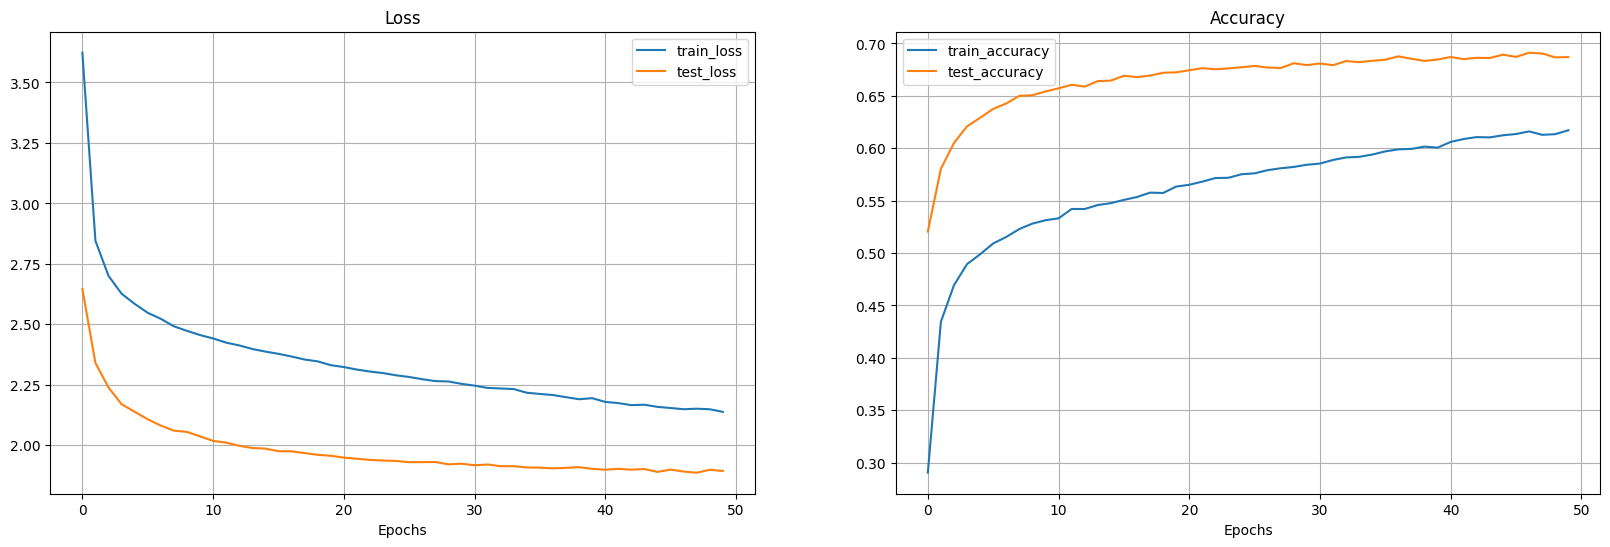

In [12]:
# Train the model
if ENABLE['train_model']:
   
    # Create optimizer
    optimizer = torch.optim.AdamW(params=effnetb2_5_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)


    # Train the classifier
    set_seeds(SEED)
    
    # Train the classifier
    effnetb2_5_results = train(model=effnetb2_5_model, 
                               train_dataloader=train_dataloader_b2,
                               test_dataloader=test_dataloader_b2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               scheduler=None,
                               epochs=EPOCHS,
                               device=device,
                               plot_curves=True,
                               amp=True,
                               writer=None)

Epoch: 5 | train_loss: 2.1181 | train_acc: 0.6248 | train_time: 3m40s | test_loss: 1.8910 | test_acc: 0.6894 | test_time: 1m40s | lr: 0.0001000000


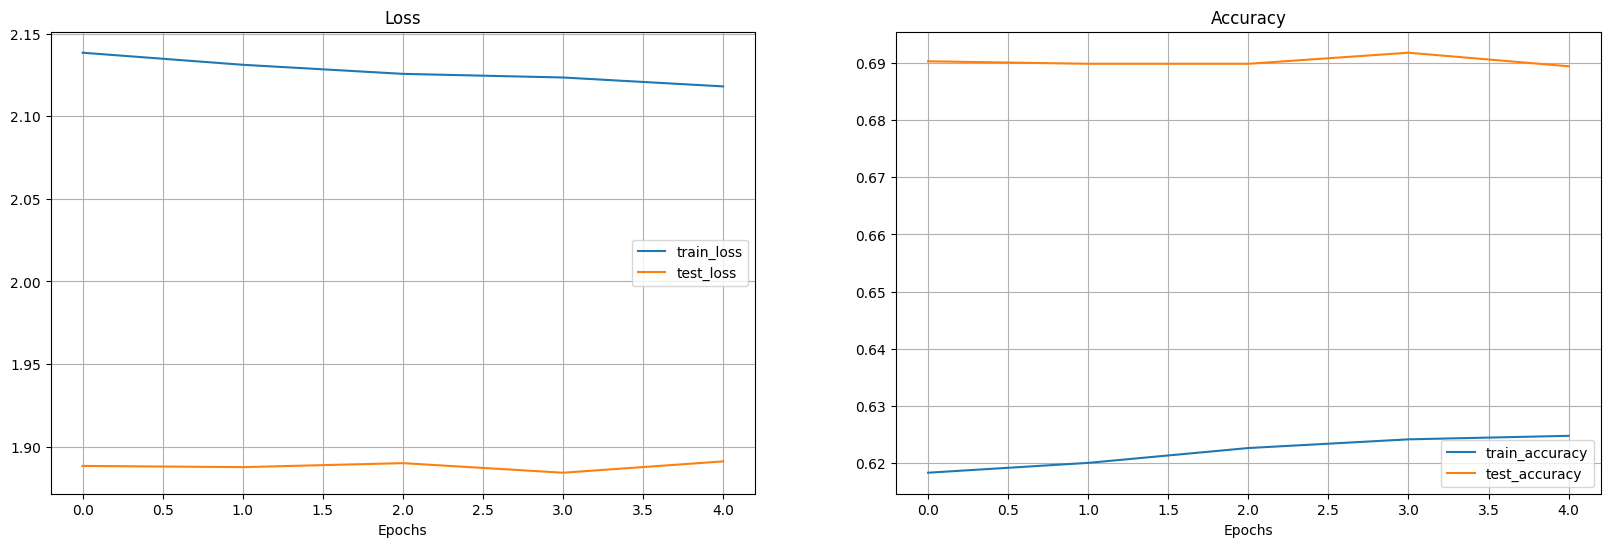

Training epoch 6...


  0%|          | 0/1184 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
if ENABLE['train_model']:
    effnetb2_5_results_2 = train(model=effnetb2_5_model, 
                               train_dataloader=train_dataloader_b2,
                               test_dataloader=test_dataloader_b2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               scheduler=None,
                               epochs=10,
                               device=device,
                               plot_curves=True,
                               amp=True,
                               writer=None)

In [ ]:
effnetb2_5_results = effnetb2_5_results.items( ) + effnetb2_5_results_2.items()

In [ ]:
# Save the EfficientNet B2 model
if ENABLE['save_model']:
    model_type="effnetb2"
    EPOCHS = 60
    LR = 0.0001
    model_name = f"{model_type}"
    effnetb2_5_model_name = model_name + ".pth"
    effnetb2_5_results_df = model_name + ".csv"
    save_model(model=effnetb2_5_model,
               target_dir=model_dir,
               model_name=effnetb2_5_model_name)
    df_results = pd.DataFrame(effnetb2_5_results)
    df_results.to_csv(os.path.join(model_dir, effnetb2_5_results_df), index=False)

## 4.3 Training Results

By adding an extra hidden layer in the fully connected classification layer, the accuracy achieved by verson 4 improves by 3.5% compared to version 1.

In [21]:
# Generate a list of best results
effnetb2_list = []

# Load EfficcientNet B2 - Version 1
model_type="effnetb2"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
effnetb2_model_name = model_name + ".pth"
effnetb2_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb2_model_name}")
print(f"Results path: {effnetb2_results_df}")

# Instantiate the model
effnetb2_model, _ = create_effnetb2(class_names=class_names)

# Load the trained weights
effnetb2_model = load_model(model=effnetb2_model,
                            model_weights_dir=model_dir,
                            model_weights_name=effnetb2_model_name)

# Load the training results
effnetb2_results = pd.read_csv(os.path.join(model_dir, effnetb2_results_df))

# Make predictions to compute the average prediction time per image
pred_list = pred_and_store(test_dir=test_dir,
                           model=effnetb2_model,
                           transform=manual_transforms_aug_norm_test,
                           class_names=class_names,
                           percent_samples=0.1,
                           device="cpu") # make predictions on CPU

# Create a dictionary with the results for this model
effnetb2_dict = {}
effnetb2_dict['model_name'] = effnetb2_model_name
effnetb2_dict['test_acc'] = effnetb2_results['test_acc'].iloc[-1]
effnetb2_dict['test_loss'] = effnetb2_results['test_loss'].iloc[-1]
effnetb2_dict['model_size [MB]'] = Path(os.path.join(model_dir, effnetb2_model_name)).stat().st_size // (1024*1024)
effnetb2_dict['Prediction time - Median [s]'] = pd.DataFrame(pred_list)['time_for_pred'].median()
effnetb2_dict['Prediction time - Mean [s]'] = pd.DataFrame(pred_list)['time_for_pred'].mean()

effnetb2_list.append(effnetb2_dict)

Model name: effnetb2_lr000100_30epochs
Model path: effnetb2_lr000100_30epochs.pth
Results path: effnetb2_lr000100_30epochs.csv
[INFO] Loading model from: ..\models\effnetb2_lr000100_30epochs.pth
[INFO] Finding all filepaths ending with '.jpg' in directory: ..\data\food-101_100_percent\test


  0%|          | 0/2525 [00:00<?, ?it/s]

In [22]:
# Load EfficcientNet B2 - Version 4
model_type="effnetb2_v4"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
effnetb2_4_model_name = model_name + ".pth"
effnetb2_4_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb2_4_model_name}")
print(f"Results path: {effnetb2_4_results_df}")

# Instantiate the model
effnetb2_4_model, _ = create_effnetb2_v2(class_names=class_names)

# Load the trained weights
effnetb2_4_model = load_model(model=effnetb2_4_model,
                              model_weights_dir=model_dir,
                              model_weights_name=effnetb2_4_model_name)

# Load the training results
effnetb2_4_results = pd.read_csv(os.path.join(model_dir, effnetb2_4_results_df))

# Make predictions to compute the average prediction time per image
pred_list = pred_and_store(test_dir=test_dir,
                           model=effnetb2_4_model,
                           transform=manual_transforms_aug_norm_test,
                           class_names=class_names,
                           percent_samples=0.1,
                           device="cpu") # make predictions on CPU

# Create a dictionary with the results for this model
effnetb2_dict = {}
effnetb2_dict['model_name'] = effnetb2_4_model_name
effnetb2_dict['test_acc'] = effnetb2_4_results['test_acc'].iloc[-1]
effnetb2_dict['test_loss'] = effnetb2_4_results['test_loss'].iloc[-1]
effnetb2_dict['model_size [MB]'] = Path(os.path.join(model_dir, effnetb2_4_model_name)).stat().st_size // (1024*1024)
effnetb2_dict['Prediction time - Median [s]'] = pd.DataFrame(pred_list)['time_for_pred'].median()
effnetb2_dict['Prediction time - Mean [s]'] = pd.DataFrame(pred_list)['time_for_pred'].mean()

effnetb2_list.append(effnetb2_dict)

Model name: effnetb2_v4_lr000100_30epochs
Model path: effnetb2_v4_lr000100_30epochs.pth
Results path: effnetb2_v4_lr000100_30epochs.csv
[INFO] Loading model from: ..\models\effnetb2_v4_lr000100_30epochs.pth
[INFO] Finding all filepaths ending with '.jpg' in directory: ..\data\food-101_100_percent\test


  0%|          | 0/2525 [00:00<?, ?it/s]

In [23]:
pd_results = pd.DataFrame(effnetb2_list)
pd_results

model_name  test_acc  test_loss  model_size [MB]  \
0     effnetb2_lr000100_30epochs.pth  0.655538   2.031124               30   
1  effnetb2_v4_lr000100_30epochs.pth  0.678958   1.923818               35   

   Prediction time - Median [s]  Prediction time - Mean [s]  
0                        0.0513                    0.052416  
1                        0.0565                    0.057622

According to the results EfficientNetB2 - Version 4 offers a 3.5% higher perdiccion accuracy than Version 1 (67.9% vs 65.6%) at the cost of a slightly larger model size (5 MB) and longer prediction time. These results confirm Version 4 as the best EfficientNetB2 model.